In [9]:
%matplotlib inline
%run setup_environment.py
%run ml_tools.py
%run custom_tools.py
%run Selene_Job.ipy

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [10]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

In [11]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [12]:
# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)
label_feature_name = 'is_somatic'

In [13]:
# choose features
feature_names = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
                 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
                 'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
                 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
                 'gene_type', label_feature_name]
impact = impact[feature_names].dropna()
    
# transform categorical features
categorical_features_names = [ 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact = pd.get_dummies(impact, columns = categorical_features_names, sparse = True)

# reduced dataset
impact = pd.concat([impact[~impact.is_somatic],
                    impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

X = impact.drop(label_feature_name, axis = 1)
y = impact[label_feature_name]

In [14]:
print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
True,20000,73.5%
False,7199,26.5%


In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)

In [16]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
X_pca = pca.transform(X)

In [18]:
X_pca

array([[-238.00053994,   89.42513399, -251.24476582],
       [-237.54833235,   39.41261791,   20.98535881],
       [-233.39196472,  551.19352457, -130.90283475],
       ...,
       [-237.53470694,  127.78339499,  -10.29614909],
       [-243.56352396, -451.29372839,  139.44827711],
       [-236.34082139,  429.00525086, -738.09187326]])

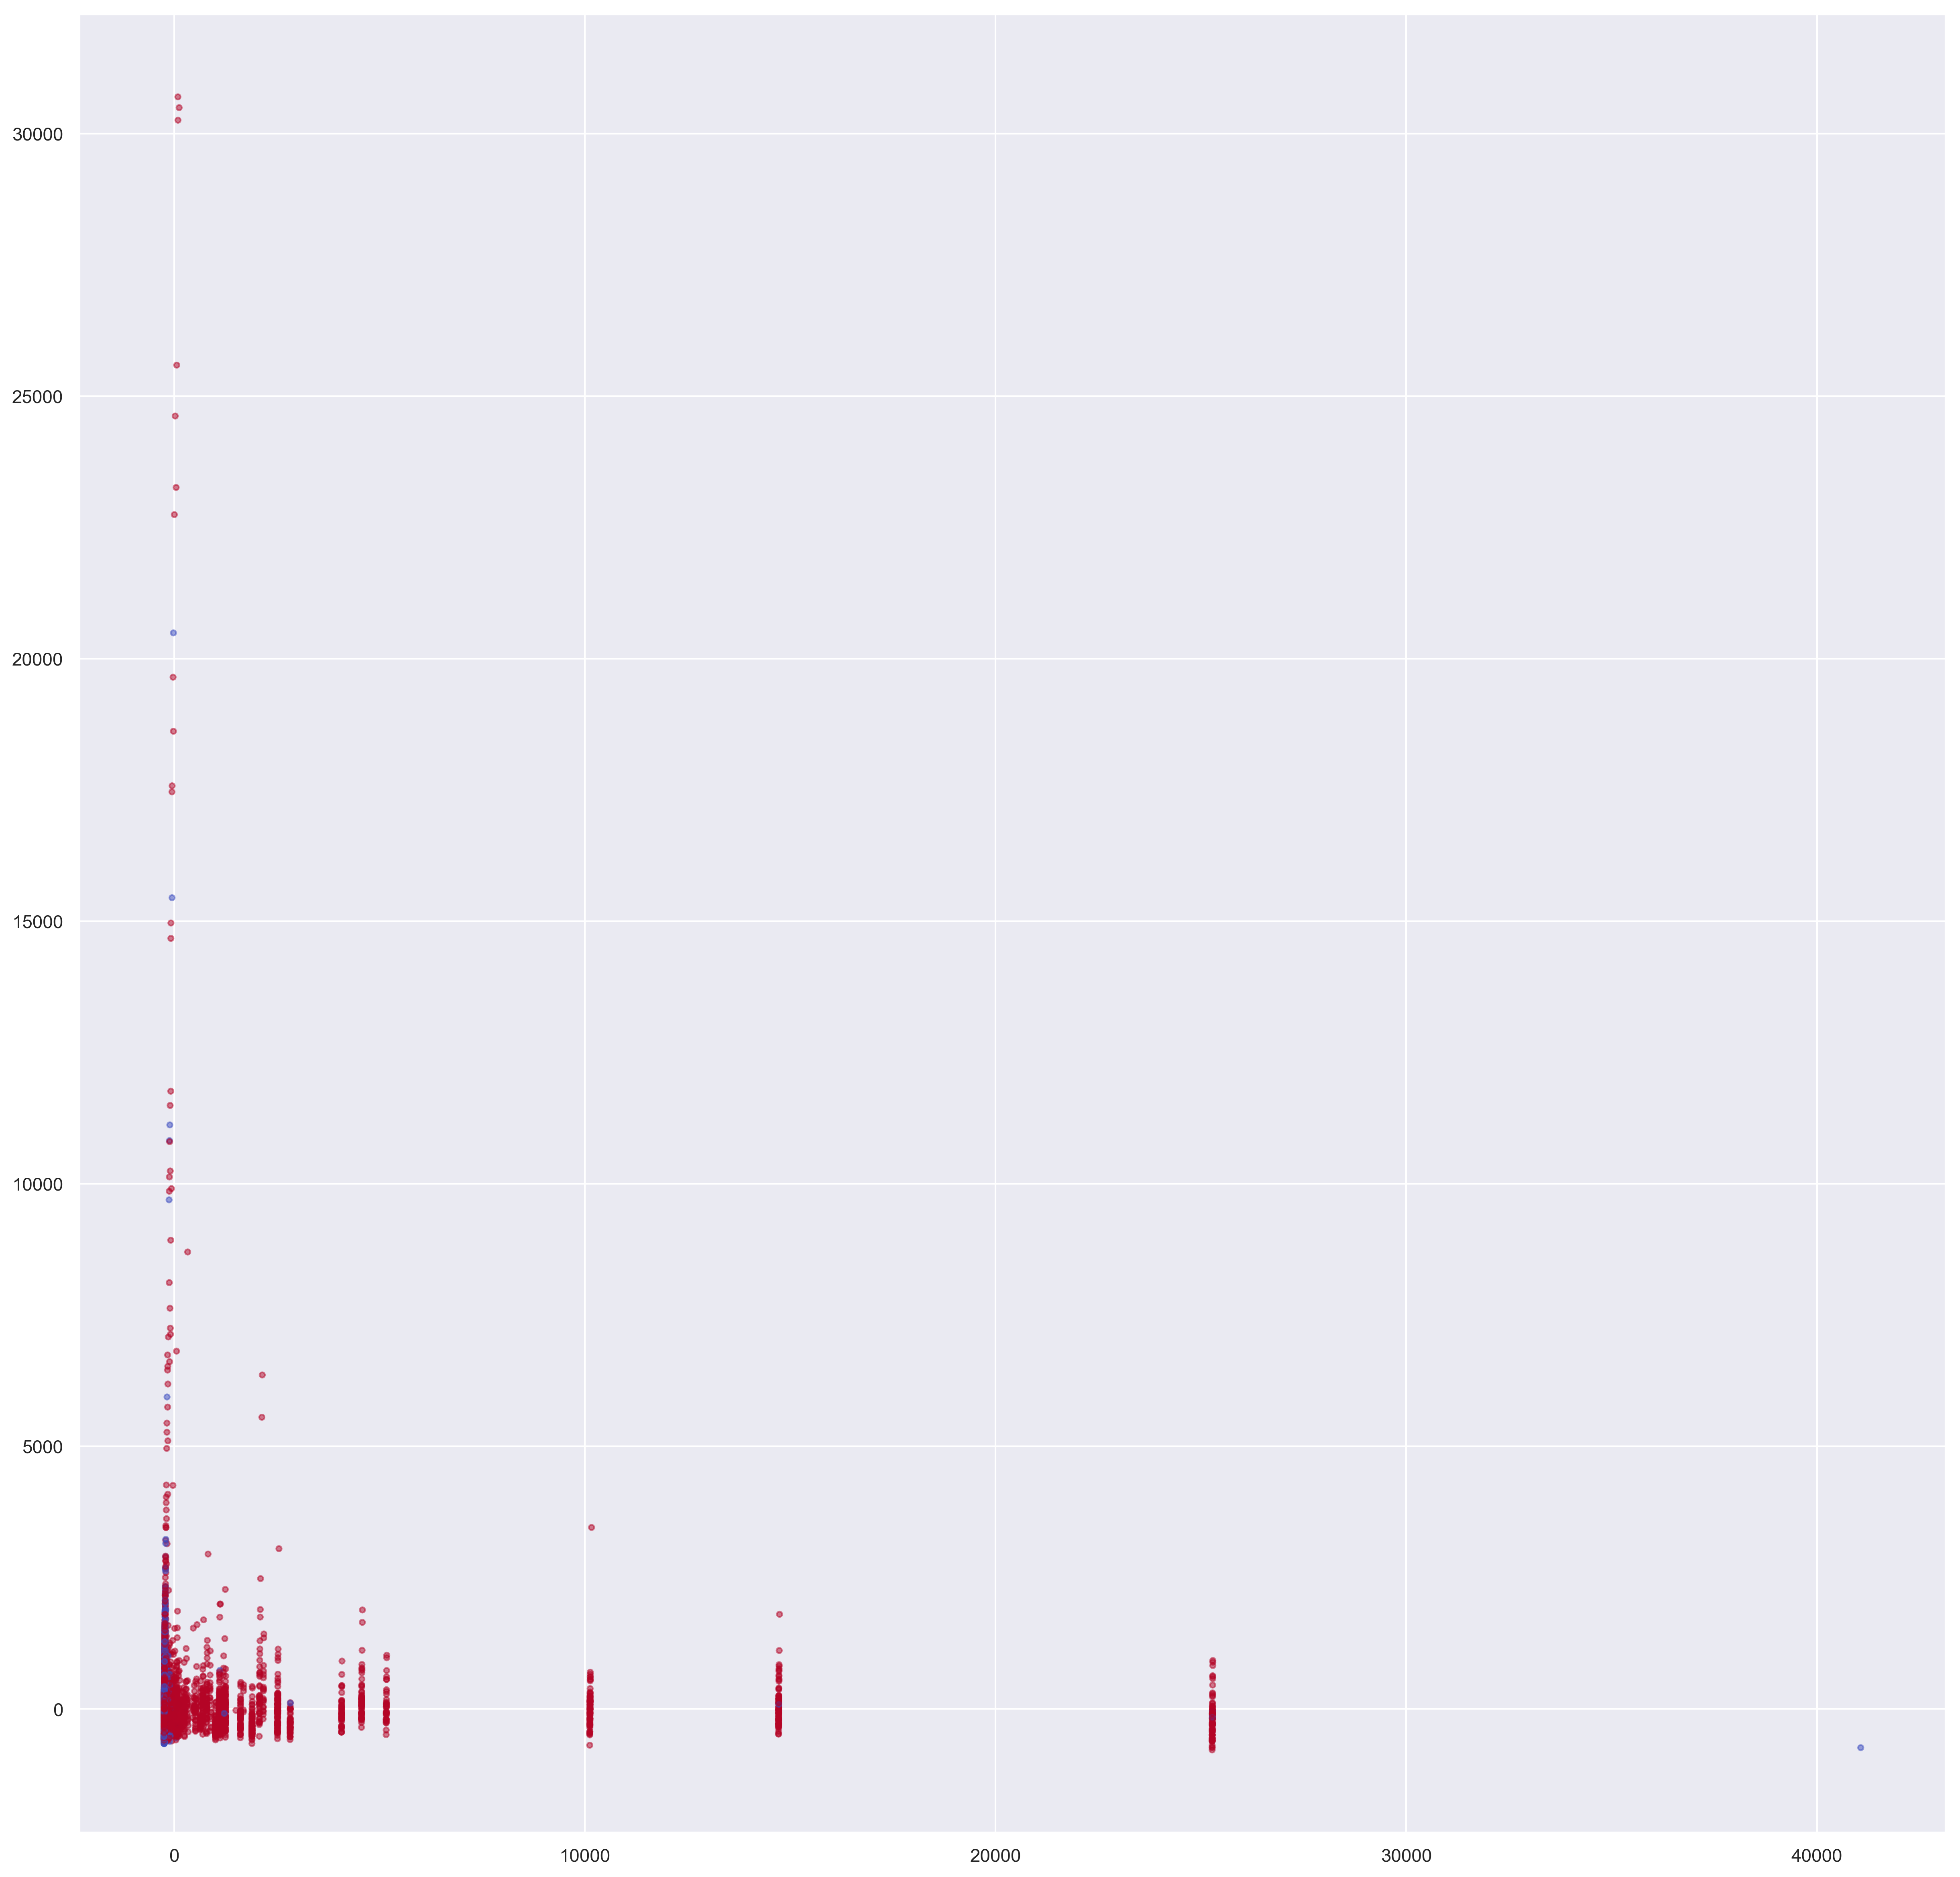

In [25]:
fig = plt.figure(figsize = (20, 20), dpi = 300)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, s = 10, alpha = 0.5, cmap = plt.cm.coolwarm)